In [ ]:
import numpy as np
import pandas as pd

sectors_data = {}
excel_file_path = 'stocks_2000_2020_data_by_sector.xlsx'
snp_price_data = pd.ExcelFile(excel_file_path)
for sheet_name in snp_price_data.sheet_names:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    sheet_data['Date'] = pd.to_datetime(sheet_data['Unnamed: 0'], format='%Y-%m-%d')
    sheet_data.set_index('Date', inplace=True)
    sheet_data.drop(columns='Unnamed: 0', inplace=True)
    sectors_data[sheet_name] = sheet_data

# 데이터프레임 생성
df = pd.DataFrame()
for sector, data in sectors_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

In [ ]:



# 전체 데이터 중 최소값과 최대값 구하기
tot_train_min = np.minimum.reduce([df.min(axis=0), df.min(axis=0)])
tot_train_max = np.maximum.reduce([df.max(axis=0), df.max(axis=0)])

# 각 주식의 범위를 계산
train_range = tot_train_max - tot_train_min


In [ ]:
import pandas as pd

end_date = pd.Timestamp('2020-12-31')
one_month = pd.DateOffset(months=1)
sixty_days = pd.DateOffset(days=60)

data_X = []
data_y = []
start_day_idx = [] # data_X를 생성하기 위한 매달 시작일 인덱스 리스트

# data_y부터 생성
start_date = pd.Timestamp('2000-04-01')

while start_date < end_date:
    end_of_period = start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    selected_data = df[(df.index >= start_date) & (df.index <= end_of_period)]

    indexing = df.index.get_loc(selected_data.index[0])

    # 각 주식에 대한 월별 평균 수익률 계산
    average_values = selected_data.mean(axis=0)

    data_y.append(average_values)
    start_day_idx.append(indexing)
    start_date = start_date + pd.DateOffset(months=1)  # Move to next month

start_date = pd.Timestamp('2000-01-01')

i = 0
while i < len(data_y):
    index_day_start = start_day_idx[i]

    nearest_index = None
    for j in range(index_day_start, index_day_start - 60, -1):
        if j < 0:
            break
        if df.index[j] in df.index:
            nearest_index = j
            break

    if nearest_index is not None:
        sixty_day_data = df.iloc[nearest_index - 60 : nearest_index]
        data_X.append(sixty_day_data)
    else:
        pass

    i += 1


In [ ]:
# 모델에 넣기 위해 list에서 array로 변환
data_X = np.array(data_X)
data_y = np.array(data_y)
print('훈련 데이터의 크기 :', data_X.shape, data_y.shape)

훈련 데이터의 크기 : (249, 60, 55) (249, 55)


In [ ]:
# 스케일링
_data_X = (data_X - tot_train_min) / (train_range + 1e-7)
_data_y = (data_y - tot_train_min) / (train_range + 1e-7)

In [ ]:
# 모델 준비 // 은닉층 개수, 활성화함수 결정
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(60, 55)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=55))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            6080      
                                                                 
 dropout (Dropout)           (None, 60, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 55)                1155      
                                                                 
Total params: 10515 (41.07 KB)
Trainable params: 10515 (41.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 옵티마이저와 손실함수 결정 및 학습 실행
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(_data_X, _data_y, epochs=400, batch_size=64)

Epoch 1/400
4/4 [==============================] - 3s 45ms/step - loss: 0.1944
Epoch 2/400
4/4 [==============================] - 0s 39ms/step - loss: 0.1772
Epoch 3/400
4/4 [==============================] - 0s 40ms/step - loss: 0.1704
Epoch 4/400
4/4 [==============================] - 0s 42ms/step - loss: 0.1641
Epoch 5/400
4/4 [==============================] - 0s 39ms/step - loss: 0.1547
Epoch 6/400
4/4 [==============================] - 0s 38ms/step - loss: 0.1443
Epoch 7/400
4/4 [==============================] - 0s 41ms/step - loss: 0.1319
Epoch 8/400
4/4 [==============================] - 0s 40ms/step - loss: 0.1208
Epoch 9/400
4/4 [==============================] - 0s 37ms/step - loss: 0.1103
Epoch 10/400
4/4 [==============================] - 0s 46ms/step - loss: 0.0998
Epoch 11/400
4/4 [==============================] - 0s 38ms/step - loss: 0.0912
Epoch 12/400
4/4 [==============================] - 0s 38ms/step - loss: 0.0826
Epoch 13/400
4/4 [==============================]

In [ ]:
#가중치 저장
model.save_weights('LSTM_AVG_prd_weight_learnByAll.h5')

In [ ]:
predictions = model.predict(_data_X)  # Replace 'test_data' with your actual test dataset

# Assuming predictions is a NumPy array
column_names = [f'Prediction_{i}' for i in range(predictions.shape[1])]
predictions_df = pd.DataFrame(predictions, columns=column_names)

# Save predictions to an Excel file
predictions_df.to_excel('model_predictions_learnedByAll.xlsx', index=False)

8/8 [==============================] - 0s 11ms/step


In [ ]:
import matplotlib.pyplot as plt

stocks = {
        'Tele' : ['VZ', 'DIS', 'T', 'CMCSA', 'EA'],
        'COND' : ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX'],
        'ENRG': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
        'HLCA' : ['JNJ', 'PFE', 'UNH','MRK','ABT'],
        'INDS' : ['BA', 'MMM','UNP','HON','RTX'],
        'MTRS': ['PPG', 'APD', 'ECL', 'SHW', 'NEM'],
        'FINC' : ['JPM', 'BRK-B', 'BAC', 'WFC', 'C'],
        'CONS' : ['PG', 'KO', 'PEP','WMT','MO'],
        'INFT' : ['AAPL','MSFT','INTC','CSCO','ORCL'],
        'UTIL' : ['NEE','DUK','D','SO','EXC'],
        'REES' : ['AMT', 'SPG', 'CCI', 'PLD', 'PSA']
    }


# 각 주식에 대한 그래프 그리기 위해 회사 리스트 생성
company_list = []
for sector in stocks:
    company_list += stocks[sector]

plt.rcParams['font.size'] = 20

# 각 주식 별 예측값&실제값 그래프 그리기
for i, company in enumerate(company_list):
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    plt.plot(_data_y[:,i], color='blue', label='Actual Stock Price of ' + company)

    # 예측 데이터 그래프
    plt.plot(predictions[:,i], color='red', label='Predicted Stock Price of ' + company)

    plt.title('Stock Price Prediction of ' + company)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

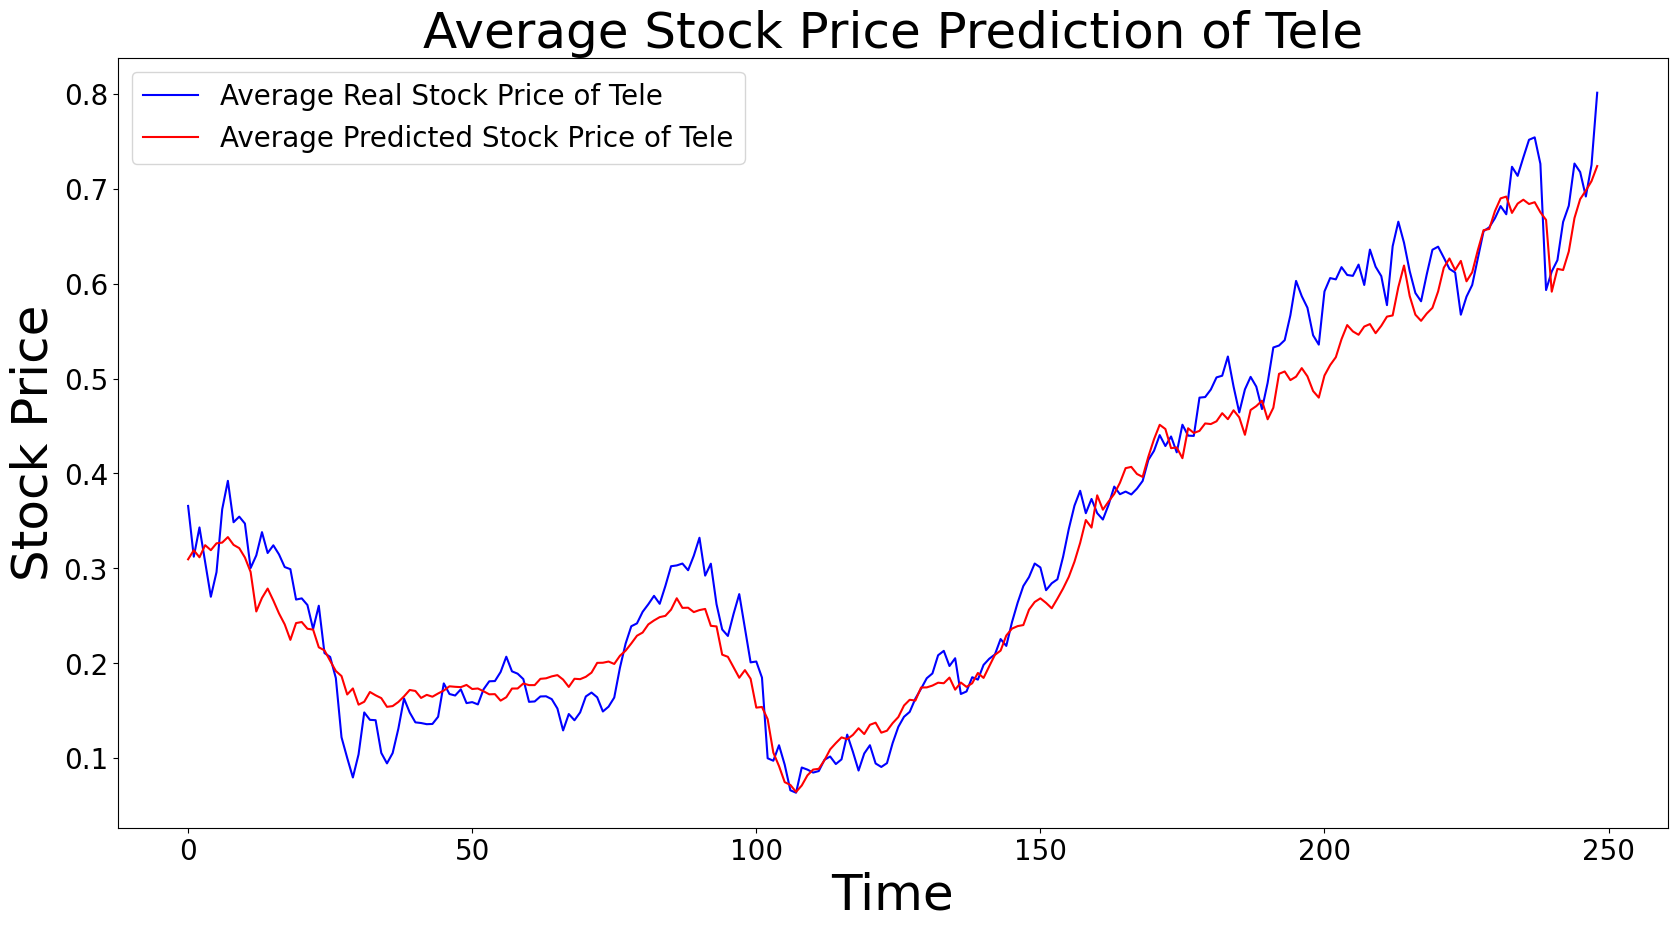

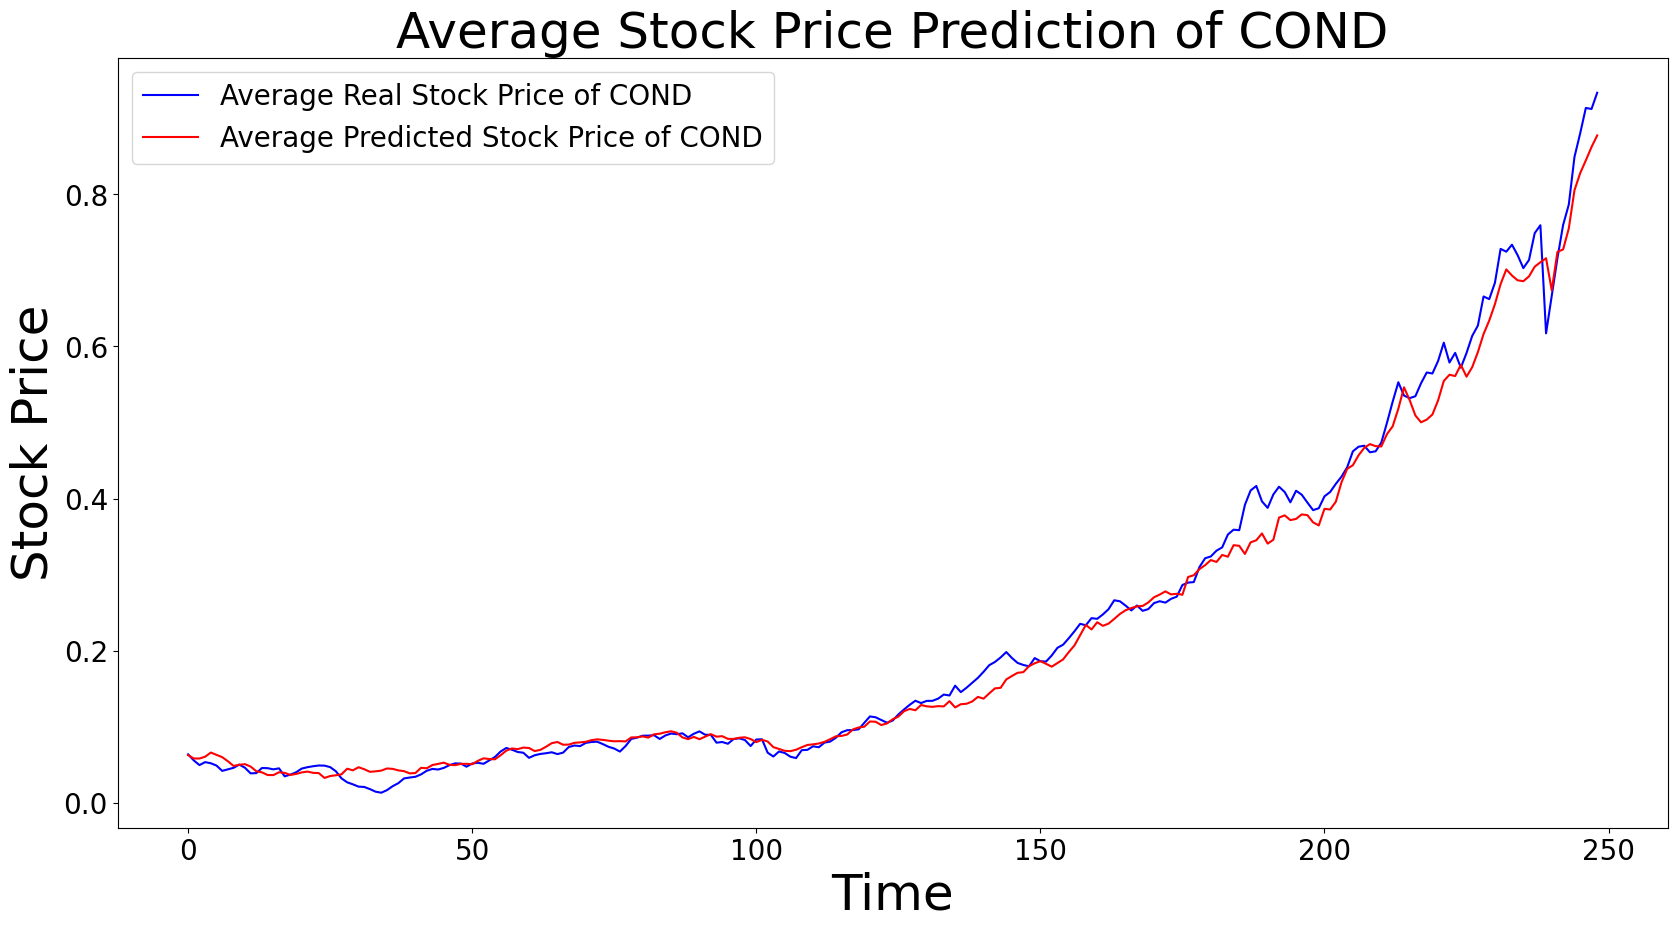

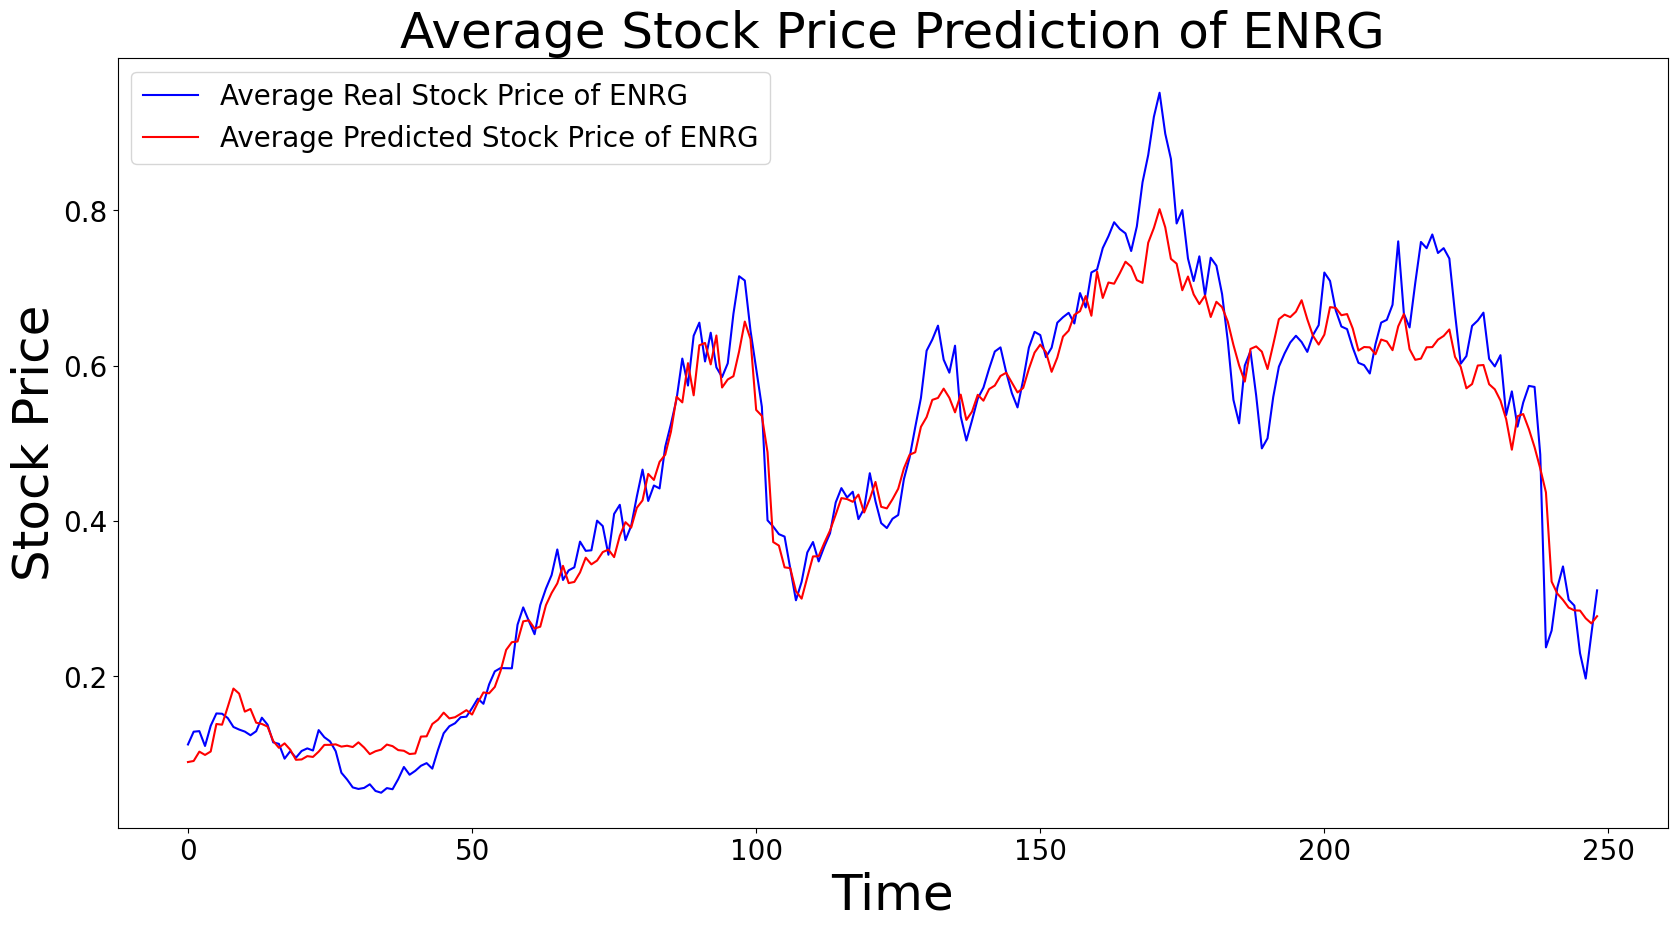

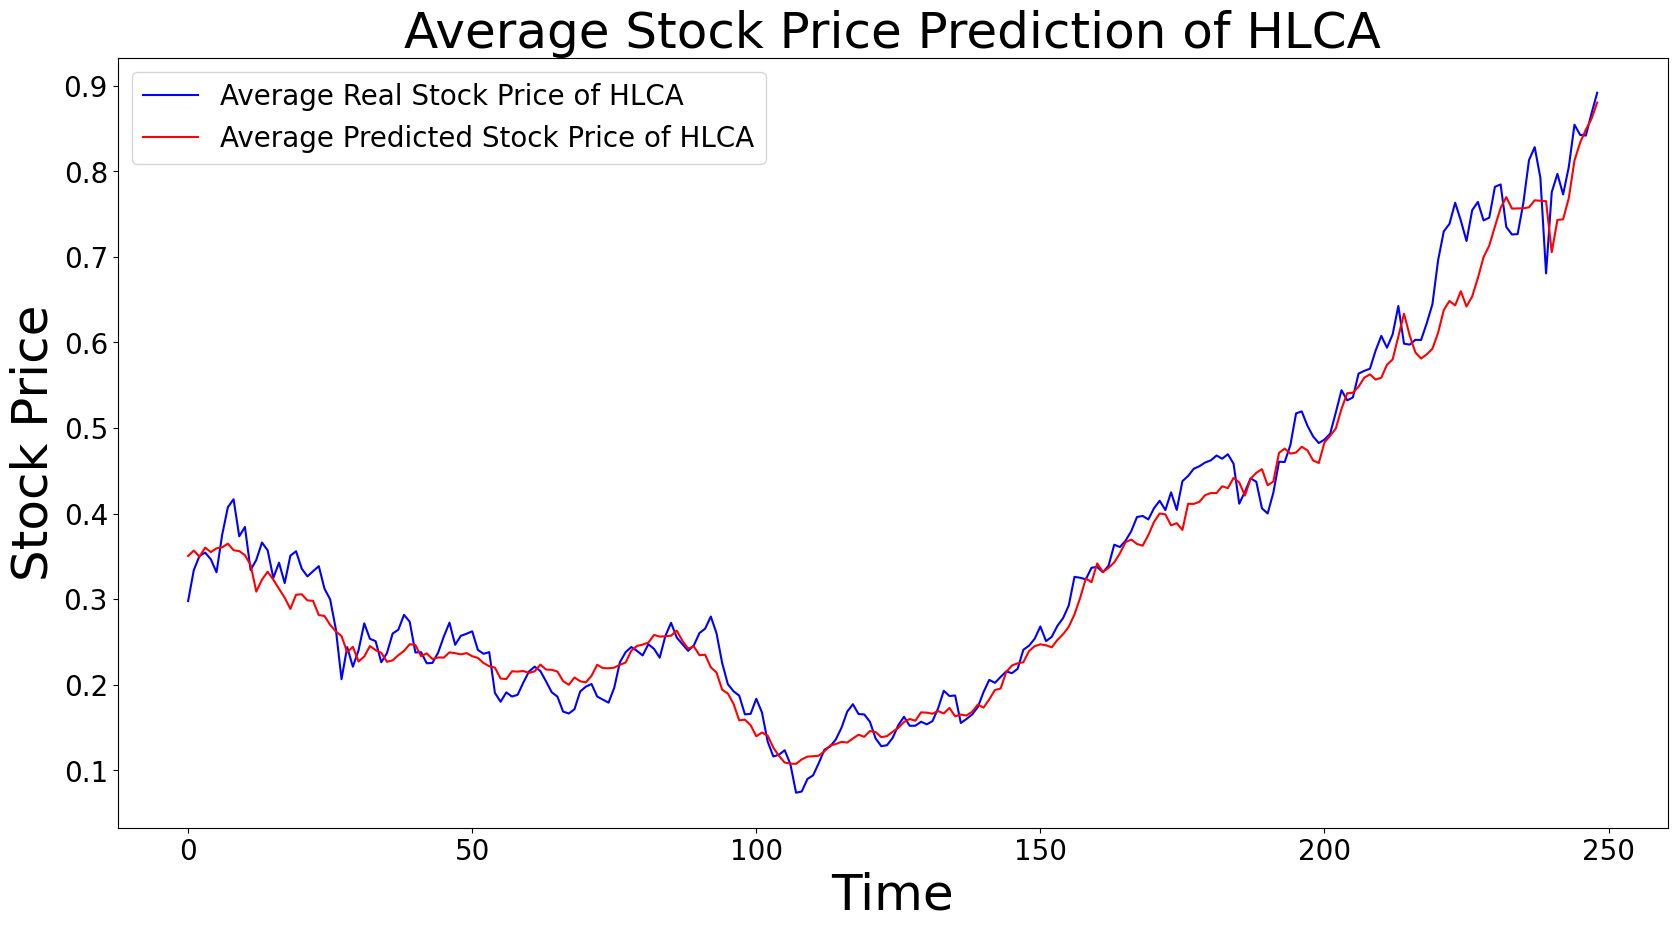

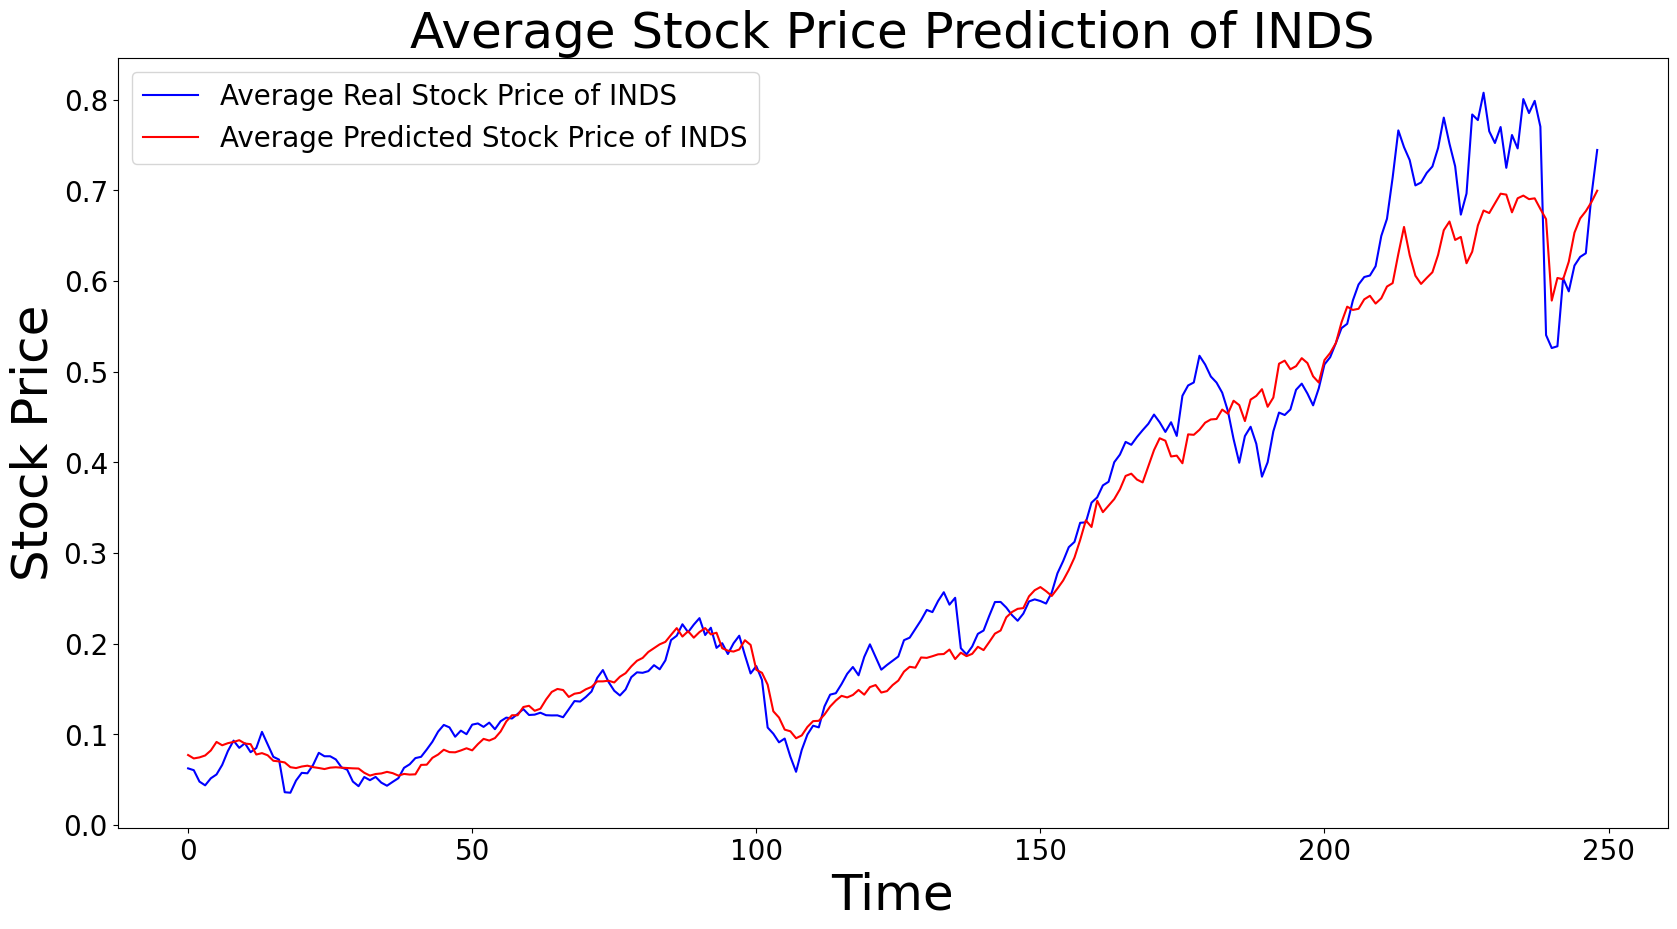

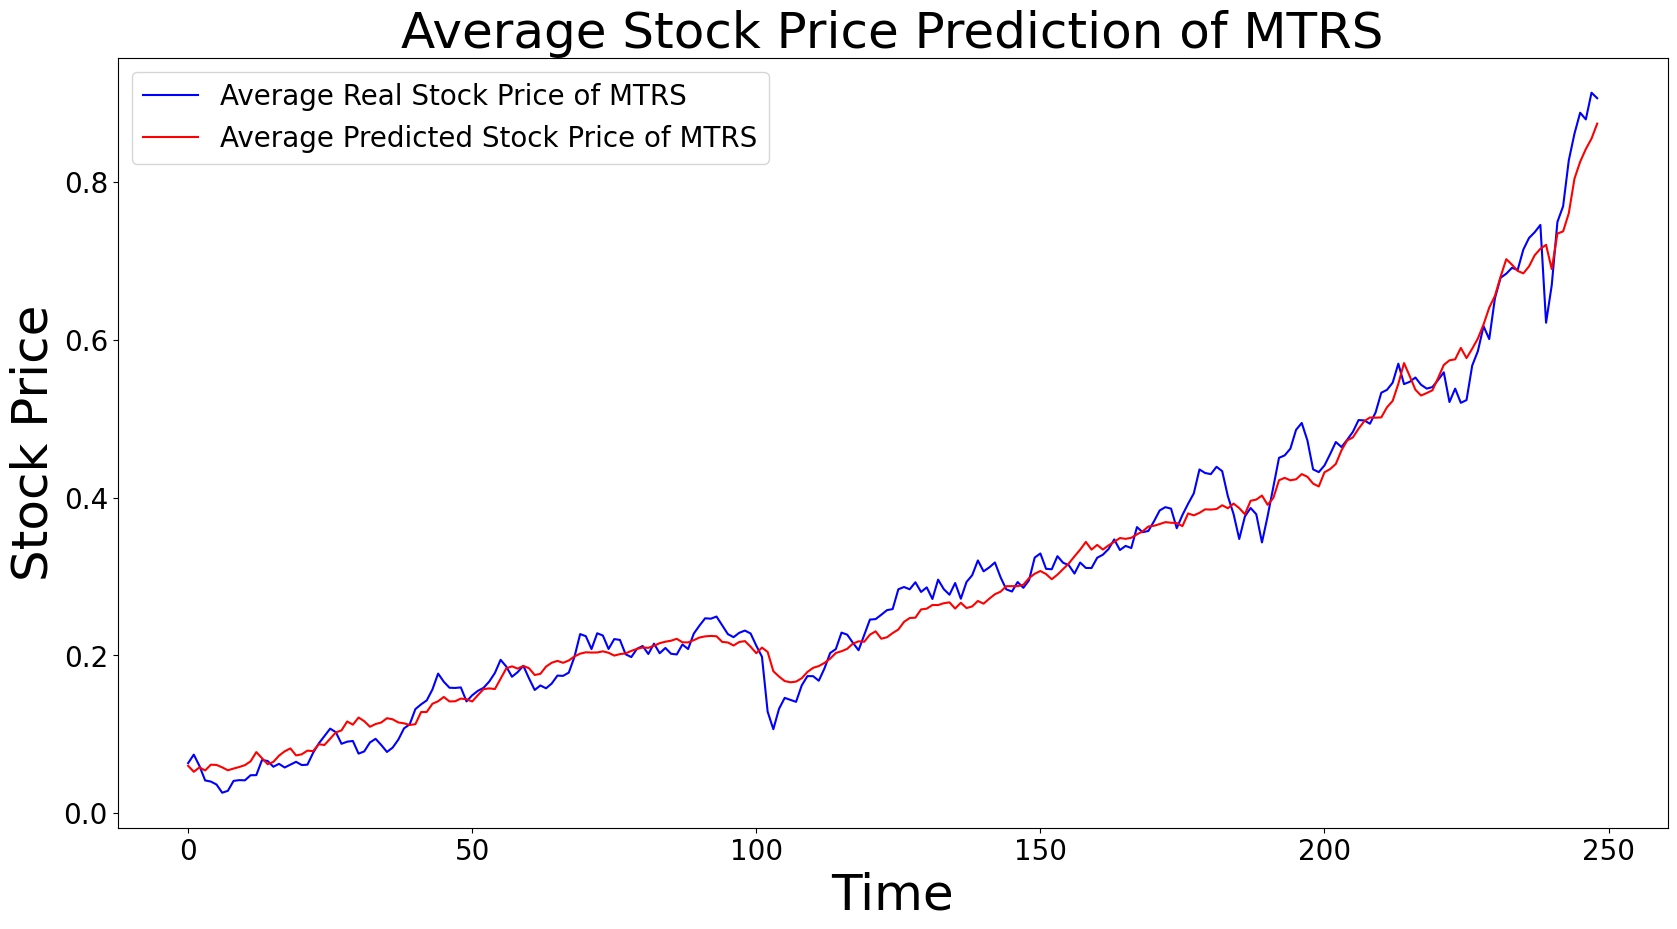

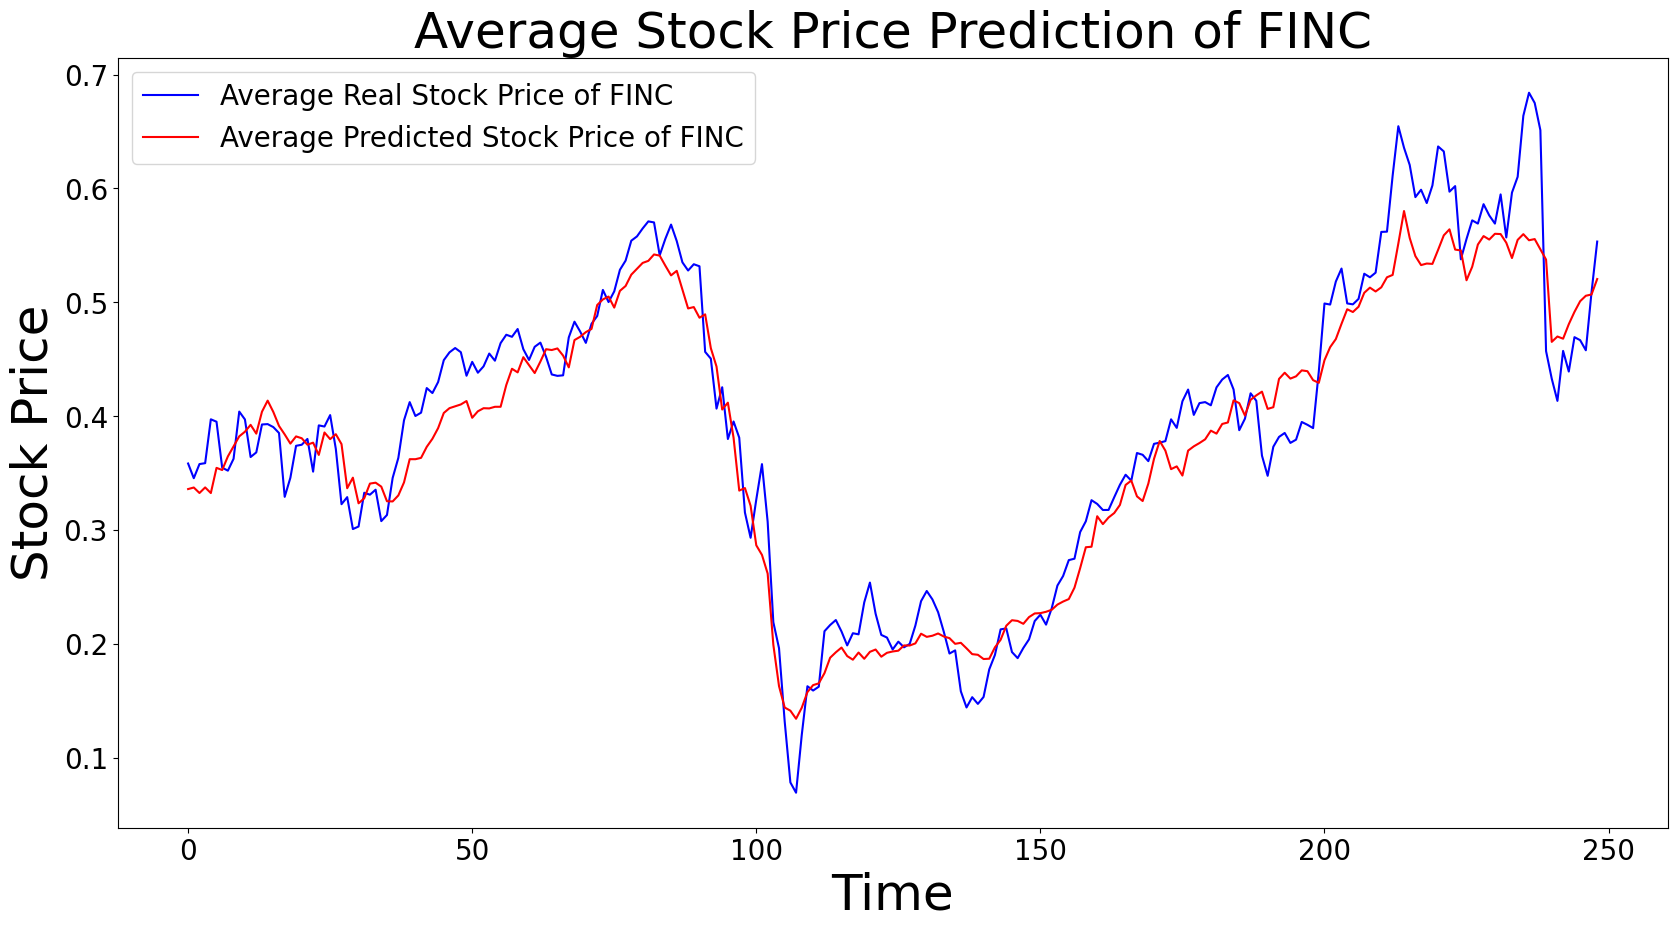

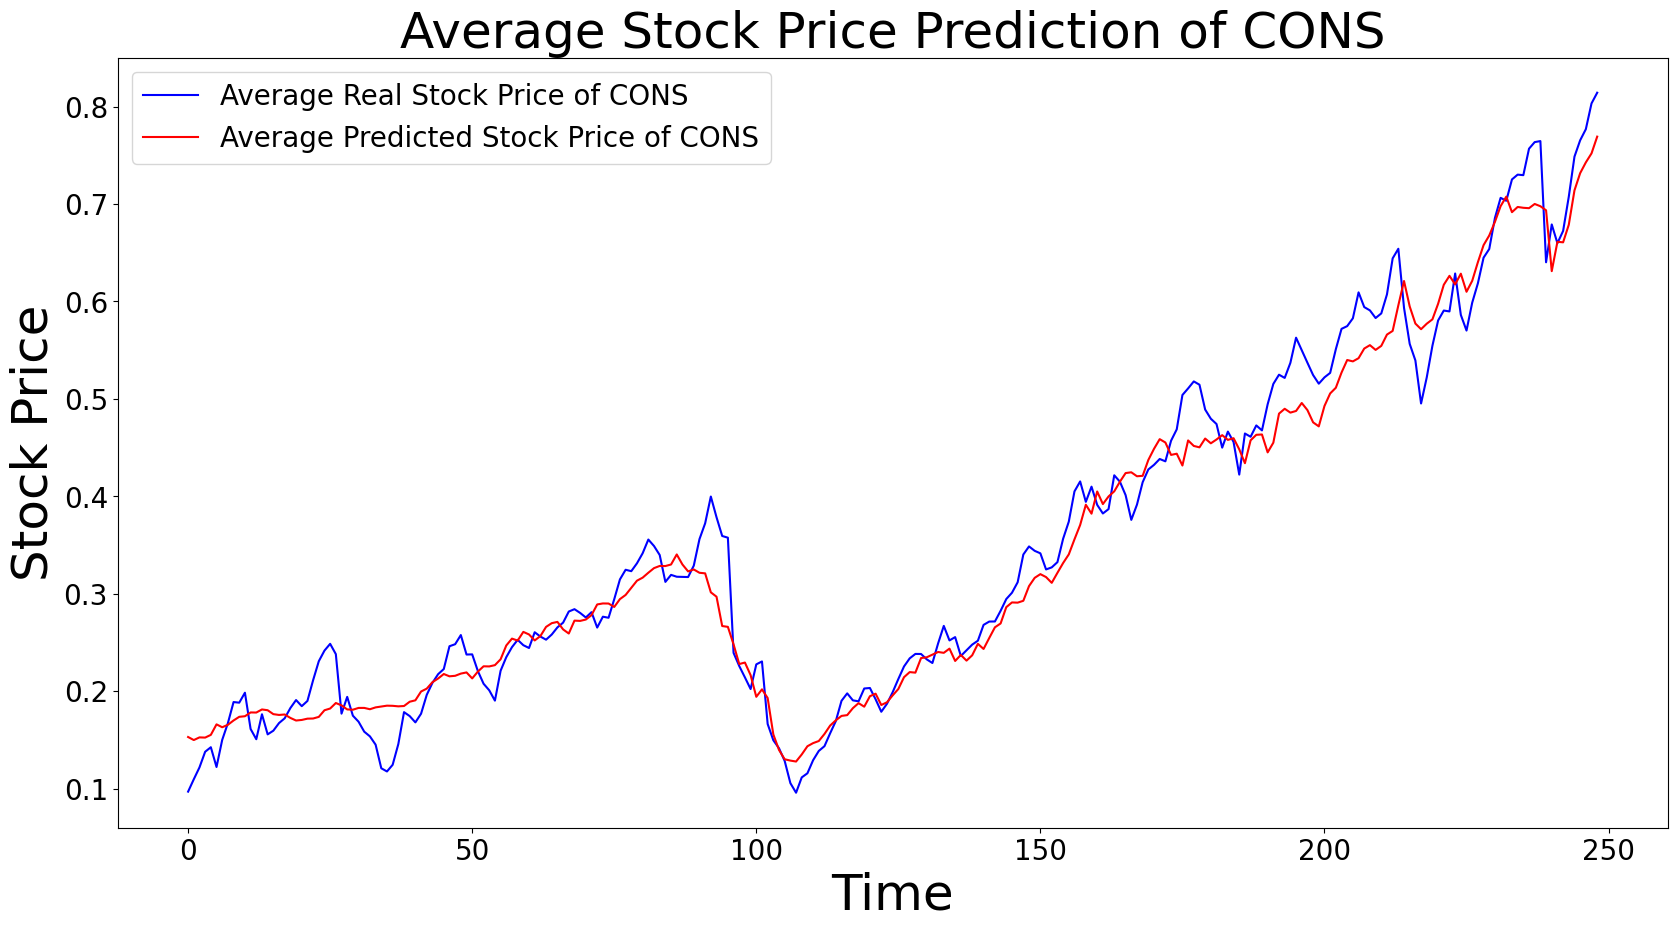

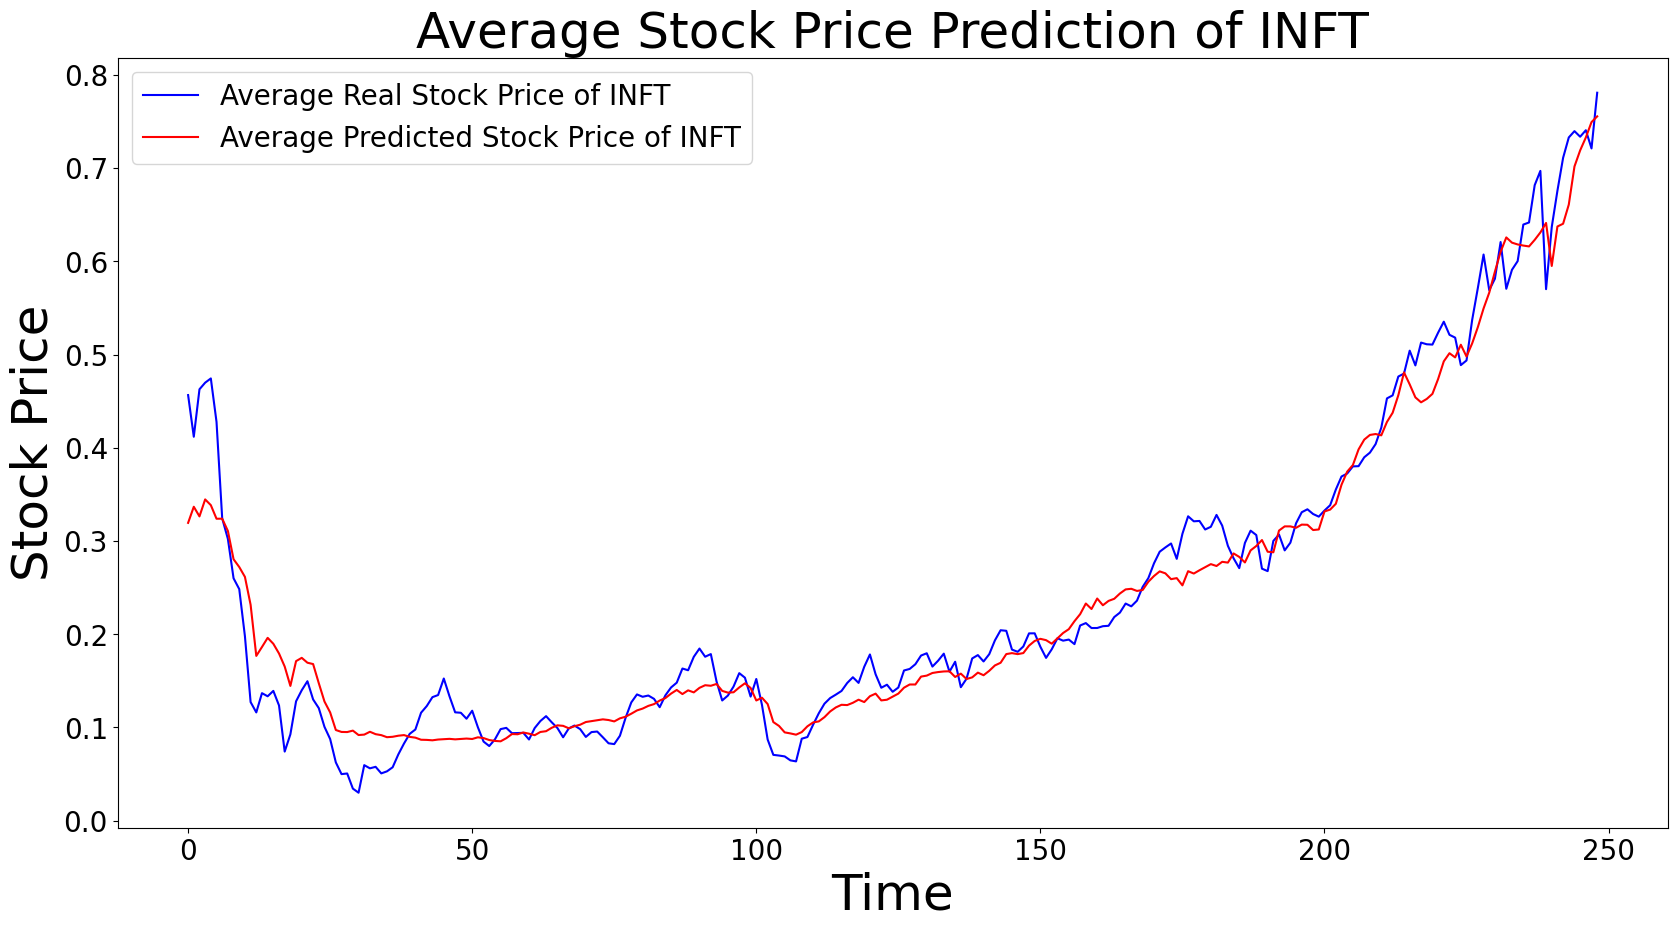

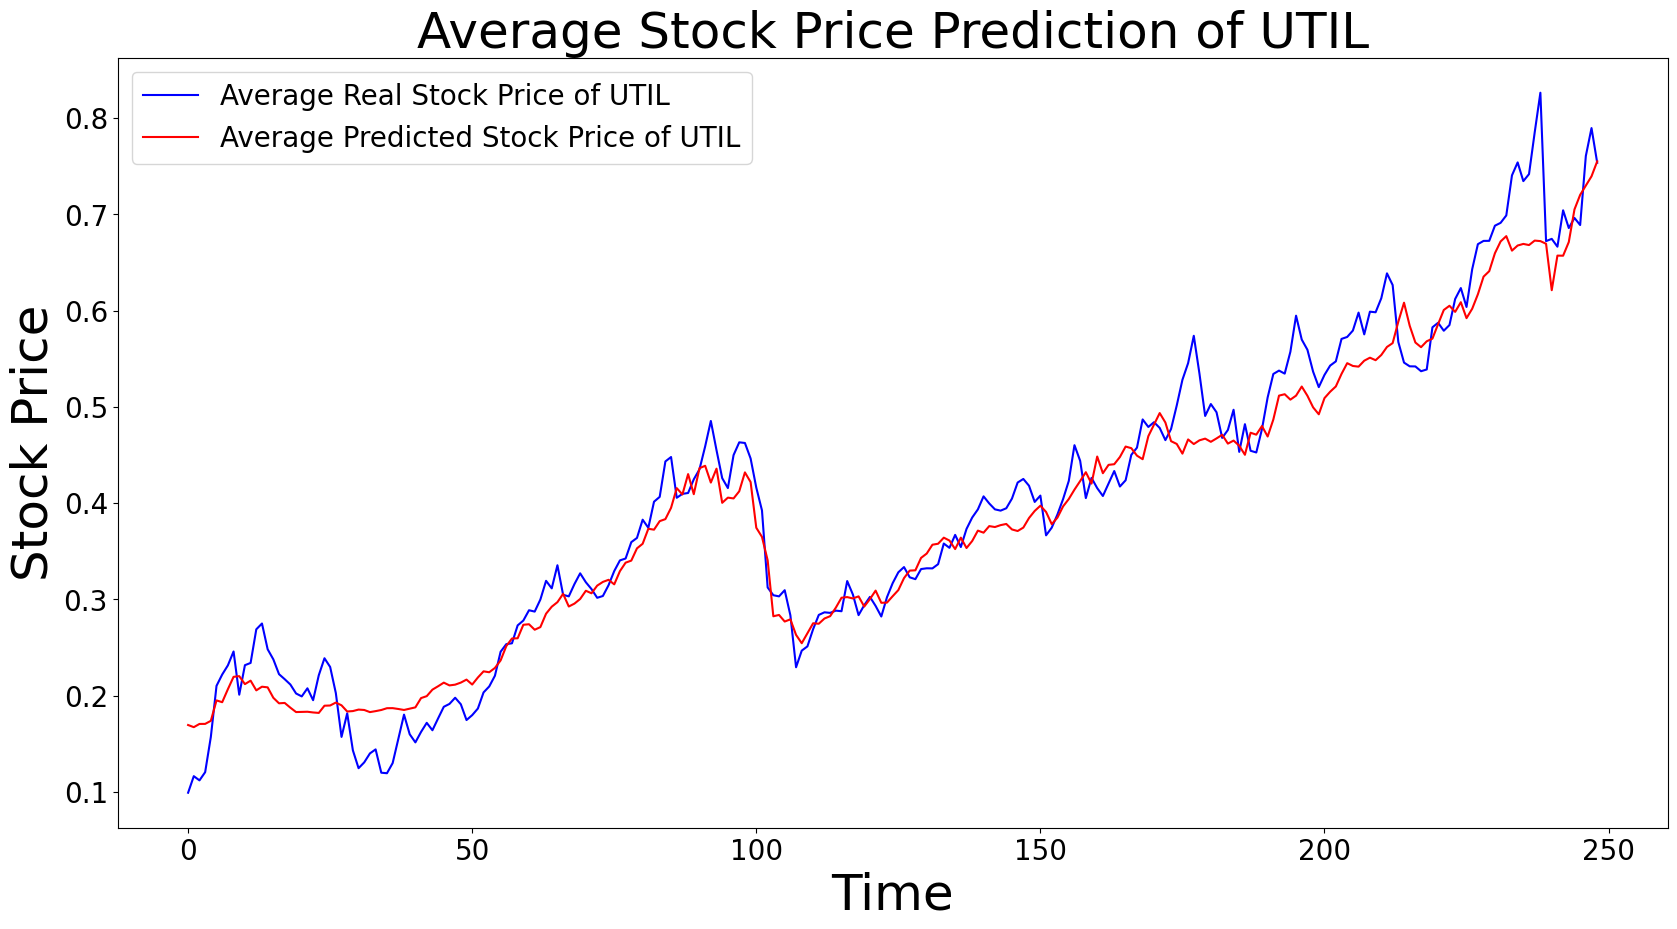

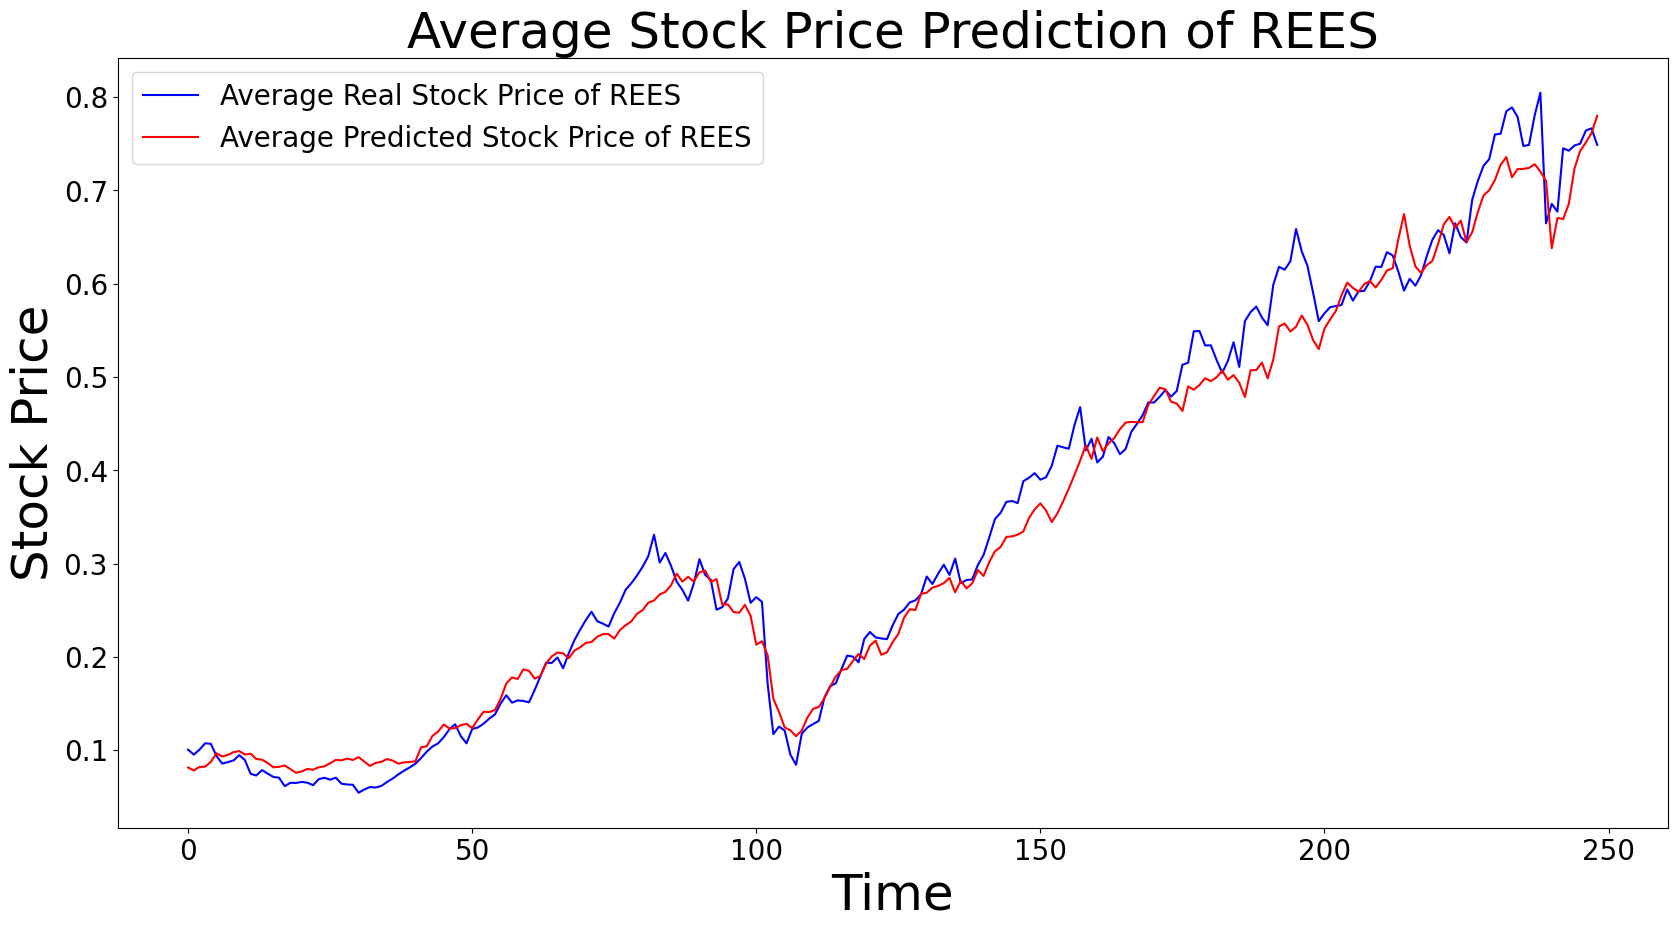

In [ ]:
# 각 섹터별 예측값&실제값 그래프 그리기

plt.rcParams['font.size'] = 20

for sector in stocks:
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    avg_test_y = np.mean([_data_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_test_y, color='blue', label='Average Real Stock Price of ' + sector)

    # 예측 데이터 그래프
    avg_pred_y = np.mean([predictions[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price of ' + sector)

    plt.title('Average Stock Price Prediction of ' + sector, fontsize=36)
    plt.xlabel('Time', fontsize=36)
    plt.ylabel('Stock Price', fontsize=36)
    plt.legend()
    plt.show()


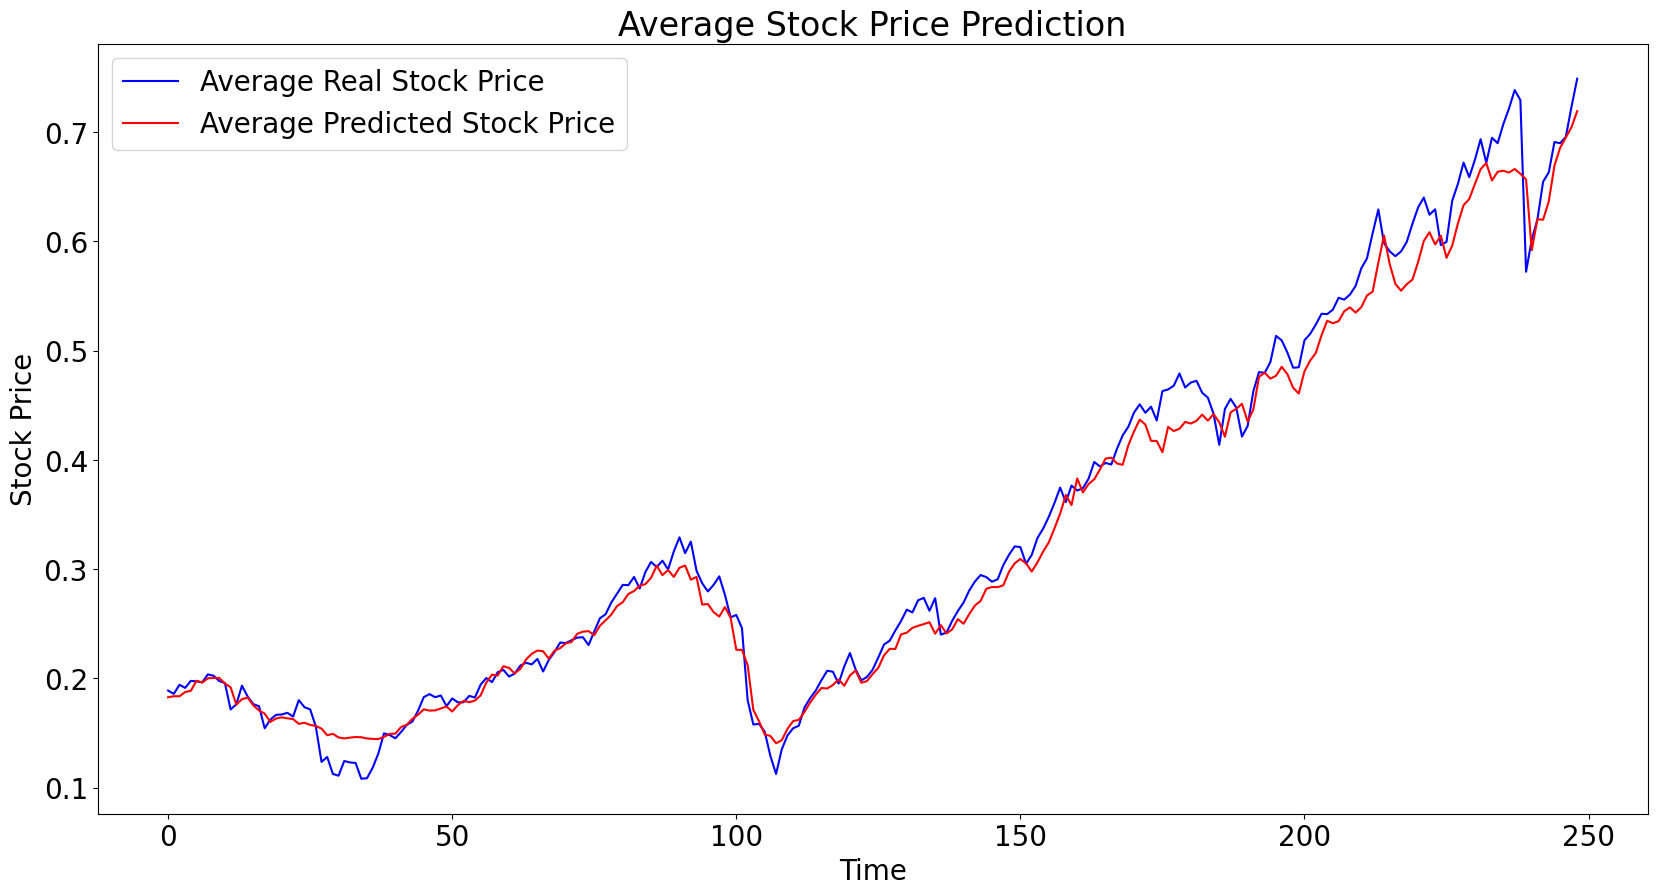

In [ ]:
# 모든 주식의 평균 예측값& 실제값 그래프 그리기

plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,10))

# 실제 데이터 그래프
avg_test_y = np.mean(_data_y, axis=1)
plt.plot(avg_test_y, color='blue', label='Average Real Stock Price')

# 예측 데이터 그래프
avg_pred_y = np.mean(predictions, axis=1)
plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price')

plt.title('Average Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
